In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy.stats import pearsonr, spearmanr
from sklearn import linear_model
from sklearn.metrics import r2_score
from adjustText import adjust_text
from functools import partial
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pd.set_option('chained_assignment',None)
from matplotlib.backends.backend_pdf import PdfPages

In [12]:
def clean_strings(val):
    if isinstance(val, str):
        clean = val.replace('<', '')
        clean = clean.replace('>', '')
        try:
            return(float(clean))
        except ValueError:
            return(np.nan)
    elif isinstance(val, float) or isinstance(val, int):
        return(float(val))
    else:
        return(np.nan)

In [13]:
main_data = pd.read_csv('C:/Users/lzoeckler/Desktop/4plex/output_data/final_dilutions.csv')
val_cols = ['HRP2_pg_ml', 'LDH_Pan_pg_ml', 'CRP_ng_ml']
main_data[val_cols] = main_data[val_cols].applymap(clean_strings)
main_data = main_data[['patient_id', 'time_point_days', 'HRP2_pg_ml',
                       'LDH_Pan_pg_ml', 'CRP_ng_ml', 'HRP2_pg_ml_dilution',
                       'HRP2_pg_ml_max_dilution', 'day0_enrollee',
                       'days_since_tx', 'initial_sample', 'got_PQ', 'age',
                       'sex', 'fever48_r', 'enrolled_from',
                       'returned_with_fever', 'when_returned_with_fever',
                       'retreated', 'when_retreated']]
main_data.head()

,patient_id,time_point_days,HRP2_pg_ml,LDH_Pan_pg_ml,CRP_ng_ml,HRP2_pg_ml_dilution,HRP2_pg_ml_max_dilution,day0_enrollee,days_since_tx,initial_sample,got_PQ,age,sex,fever48_r,enrolled_from,returned_with_fever,when_returned_with_fever,retreated,when_retreated
0,pa-001,3,318702.59,142.30,5678.58,2500,312500000,1.0,3.0,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN
1,pa-001,7,73737.79,179.34,1021.09,2500,125000,1.0,9.0,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN
2,pa-001,14,4138.79,14.41,7064.05,50,50,1.0,17.0,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN
3,pa-001,21,1377.18,38.94,2413.65,50,50,1.0,23.0,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN
4,pa-001,28,2024.41,29.86,92.87,50,50,1.0,NaN,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN


In [14]:
rebuilt_data = []
for pid in main_data['patient_id'].unique():
    sub_data = main_data.loc[main_data['patient_id'] == pid]
    if len(sub_data) < 4:
        continue
    all_times = sub_data['time_point_days'].unique().tolist()
    start_val = sub_data.loc[sub_data['time_point_days'] == min(all_times), 'HRP2_pg_ml'].item()
    if start_val < 10:
        continue
    rebuilt_data.append(sub_data)
rebuilt_data = pd.concat(rebuilt_data)
rebuilt_data[val_cols] = rebuilt_data[val_cols].applymap(np.log10)
rebuilt_data.head()

,patient_id,time_point_days,HRP2_pg_ml,LDH_Pan_pg_ml,CRP_ng_ml,HRP2_pg_ml_dilution,HRP2_pg_ml_max_dilution,day0_enrollee,days_since_tx,initial_sample,got_PQ,age,sex,fever48_r,enrolled_from,returned_with_fever,when_returned_with_fever,retreated,when_retreated
0,pa-001,3,5.503386,2.153205,3.754240,2500,312500000,1.0,3.0,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN
1,pa-001,7,4.867690,2.253677,3.009064,2500,125000,1.0,9.0,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN
2,pa-001,14,3.616873,1.158664,3.849054,50,50,1.0,17.0,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN
3,pa-001,21,3.138991,1.590396,3.382674,50,50,1.0,23.0,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN
4,pa-001,28,3.306298,1.475090,1.967875,50,50,1.0,NaN,NaN,1.0,2,female,1.0,health facility,NaN,NaN,NaN,NaN


In [15]:
analyte_name_dict = {'HRP2_pg_ml': ('HRP2', 'pg/ml'), 'LDH_Pan_pg_ml': ('LDH_Pan', 'pg/ml'),
                     'LDH_Pv_pg_ml': ('LDH_Pv', 'pg/ml'), 'CRP_ng_ml': ('CRP', 'ng/ml')}

In [28]:
def get_coef(df):
    regr = linear_model.LinearRegression()
    time = df['time_point_days'].values.reshape(-1,1)
    val = df['HRP2_pg_ml'].values.reshape(-1,1)
    regr.fit(time, val)
    coef = np.float(regr.coef_)
    pred = regr.predict(time)
    score = r2_score(val, pred)
    return (coef, score)

In [23]:
problem_pids = ['pa-017', 'pa-020', 'pa-026', 'pa-035', 'pa-049',
                'pa-072', 'pa-077', 'pa-109', 'pa-113', 'pa-114',
                'pa-124', 'pa-129', 'pa-140', 'pa-149', 'pa-169']

In [24]:
def set_group_color(df):
    if df['infection_category'] == 'symptomatic':
        return 'red'
    elif df['infection_category'] == 'chronic':
        return 'yellow'
    elif df['infection_category'] == 'clearing':
        return 'green'
    elif df['infection_category'] == 'uninfected':
        return 'blue'
    elif df['infection_category'] == 'uncategorized':
        return 'black'

In [29]:
good_df = []
bad_df = []
for pid in ['pa-026']:
    pid_data = rebuilt_data.loc[rebuilt_data['patient_id'] == pid]
    pid_data.sort_values('time_point_days', inplace=True)
    all_times = pid_data['time_point_days'].unique().tolist()
    all_times.sort()
    max_run = 3
    the_rest = []
    i = 0
    end_val = 4
    baddest_section = []
    the_rest_set = set([0])
    while (end_val <= len(all_times)) & (len(the_rest_set) != 0):
        next_start = None
        time_vals = all_times[i:end_val]
        coef_data = pid_data.loc[pid_data['time_point_days'].isin(time_vals)]
        avg_val = coef_data['HRP2_pg_ml'].mean()
        coef, score = get_coef(coef_data)
        extended_time = all_times[end_val:end_val + 4]
        if len(extended_time) > 2:
            extended_data = pid_data.loc[pid_data['time_point_days'].isin(extended_time)]
            extended_coef, extended_score = get_coef(extended_data)
        else:
            extended_score = 0
        while (coef > -.03) & (len(time_vals) != 1) & (avg_val > 2.5) & (end_val < len(all_times)):
            end_val = end_val + 1
            time_vals = all_times[i:end_val]
            coef_data = pid_data.loc[pid_data['time_point_days'].isin(time_vals)]
            coef, score = get_coef(coef_data)
            avg_val = coef_data['HRP2_pg_ml'].mean()
            end_data = pid_data.loc[pid_data['time_point_days'].isin(time_vals[-4:])]
            end_coef, end_score = get_coef(end_data)
            extended_time = all_times[end_val:end_val + 4]
            if len(extended_time) > 2:
                extended_data = pid_data.loc[pid_data['time_point_days'].isin(extended_time)]
                extended_coef, extended_score = get_coef(extended_data)
            else:
                extended_score = 0
            condition1 = (coef > -.03) & (avg_val > 2.5) & (score < .3) & (end_score < .4)
            condition2 = (coef > 0) & (avg_val > 2.5) & (score < .3)
            if condition1 or condition2:
                current_run = len(time_vals)
                next_start = end_val - 1
                if current_run > max_run:
                    max_run = current_run
                    baddest_section = time_vals
        if next_start:
            i = next_start
        else:
            i = end_val - 3
        try:
            all_times[i + 4]
            end_val = i + 4
        except:
            the_rest = all_times[i:]
            the_rest_set = set(the_rest) - set(time_vals)
            end_val = i + len(the_rest)
    good_vals = pid_data.loc[~pid_data['time_point_days'].isin(baddest_section)]
    good_df.append(good_vals)
    bad_vals = pid_data.loc[pid_data['time_point_days'].isin(baddest_section)]
    bad_df.append(bad_vals)
good_df = pd.concat(good_df)
bad_df = pd.concat(bad_df)

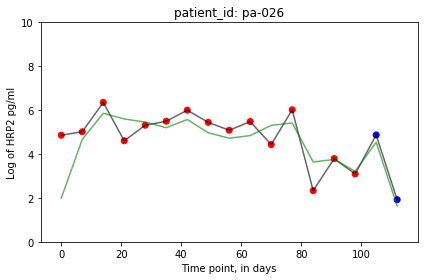

In [30]:
for pid in ['pa-026']:
    good_vals = good_df.loc[good_df['patient_id'] == pid]
    good_vals['group'] = 'blue'
    bad_vals = bad_df.loc[bad_df['patient_id'] == pid]
    bad_vals['group'] = 'red'
    combo = pd.concat([good_vals, bad_vals])
    combo = combo.sort_values('time_point_days')
    f = plt.figure()
    f.add_subplot()
    title = "patient_id: {}".format(pid)
    plt.plot(combo['time_point_days'], combo['HRP2_pg_ml'],
            c='black', alpha=0.6)
    plt.plot(combo['time_point_days'], combo['LDH_Pan_pg_ml'], c='green', alpha=0.6)
    plt.scatter(combo['time_point_days'], combo['HRP2_pg_ml'],
                c=combo['group'])
    plt.title(title)
    plt.ylim(0,10)
    plt.xlabel('Time point, in days')
    plt.ylabel('Log of HRP2 pg/ml')
    plt.tight_layout()
    plt.show()
    plt.close()

In [9]:
good_df = []
bad_df = []
# k = 0
# for pid in rebuilt_data['patient_id'].unique():
for pid in ['pa-026']:
    pid_data = rebuilt_data.loc[rebuilt_data['patient_id'] == pid]
    pid_data.sort_values('time_point_days', inplace=True)
    all_times = pid_data['time_point_days'].unique().tolist()
    all_times.sort()
    max_run = 3
    the_rest = []
    i = 0
    end_val = 4
    baddest_section = []
    the_rest_set = set([0])
    while (end_val <= len(all_times)) & (len(the_rest_set) != 0):
        next_start = None
        time_vals = all_times[i:end_val]
#         print('INITIAL VALS', time_vals)
        coef_data = pid_data.loc[pid_data['time_point_days'].isin(time_vals)]
        avg_val = coef_data['HRP2_pg_ml'].mean()
        coef, score = get_coef(coef_data)
        extended_time = all_times[end_val:end_val + 4]
        if len(extended_time) > 2:
            extended_data = pid_data.loc[pid_data['time_point_days'].isin(extended_time)]
            extended_coef, extended_score = get_coef(extended_data)
        else:
            extended_score = 0
        while (coef > -.03) & (len(time_vals) != 1) & (avg_val > 2.5) & (end_val < len(all_times)):
            end_val = end_val + 1
            time_vals = all_times[i:end_val]
            coef_data = pid_data.loc[pid_data['time_point_days'].isin(time_vals)]
            coef, score = get_coef(coef_data)
            avg_val = coef_data['HRP2_pg_ml'].mean()
            end_data = pid_data.loc[pid_data['time_point_days'].isin(time_vals[-4:])]
            end_coef, end_score = get_coef(end_data)
            extended_time = all_times[end_val:end_val + 4]
            if len(extended_time) > 2:
                extended_data = pid_data.loc[pid_data['time_point_days'].isin(extended_time)]
                extended_coef, extended_score = get_coef(extended_data)
            else:
                extended_score = 0
#             print('FIRST WHILE, coef: {}, times: {}, avg: {}, r2: {}'.format(coef, time_vals, avg_val, score))
#             print('TIME VALS', time_vals)
#             print('NORMAL COEF', coef)
#             print('NORMAL SCORE', score)
#             print('END COEF', end_coef)
#             print('END SCORE', end_score)
#             print('EXTENDED TIMES', extended_time)
#             print('EXTENDED COEF', extended_coef)
#             print('EXTENDED SCORE', extended_score)
#             print('AVG_VAL', avg_val)
            condition1 = (coef > -.03) & (avg_val > 2.5) & (score < .3) & (end_score < .4)
            condition2 = (coef > 0) & (avg_val > 2.5) & (score < .3)
            if condition1 or condition2:
#                 print('here')
                current_run = len(time_vals)
                next_start = end_val - 1
                if current_run > max_run:
                    max_run = current_run
                    baddest_section = time_vals
#                     print(baddest_section)
#                 print('SECOND WHILE, coef: {}, times: {}, avg: {}, r2: {}'.format(coef, time_vals, avg_val, score))
#             print('-----------------------')
        if next_start:
            i = next_start
        else:
            i = end_val - 3
        try:
            all_times[i + 4]
            end_val = i + 4
        except:
            the_rest = all_times[i:]
            the_rest_set = set(the_rest) - set(time_vals)
            end_val = i + len(the_rest)
    good_vals = pid_data.loc[~pid_data['time_point_days'].isin(baddest_section)]
    good_df.append(good_vals)
    bad_vals = pid_data.loc[pid_data['time_point_days'].isin(baddest_section)]
    bad_df.append(bad_vals)
#     if len(bad_vals) > 0:
#         print(pid) 
#         k += 1
good_df = pd.concat(good_df)
bad_df = pd.concat(bad_df)
# print(k)

pa-026
1


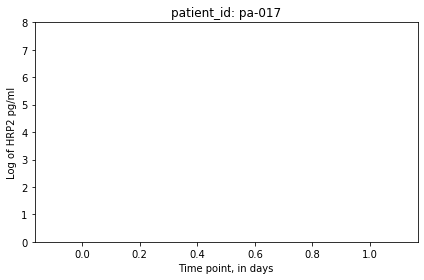

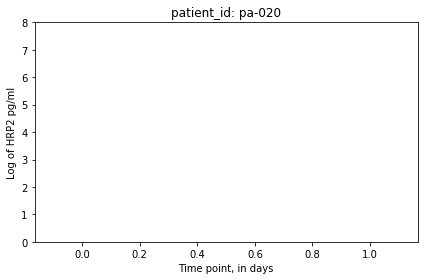

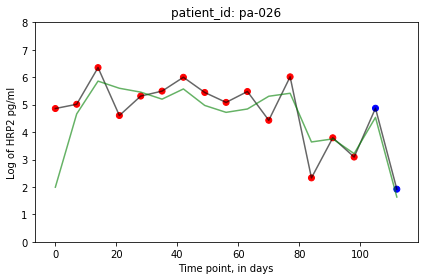

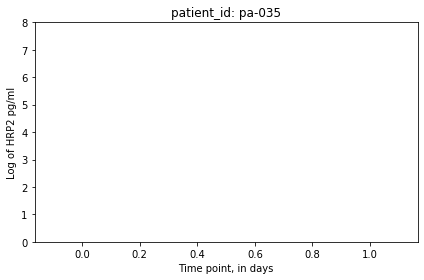

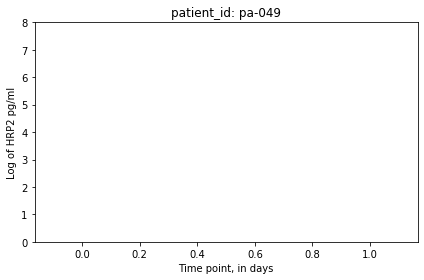

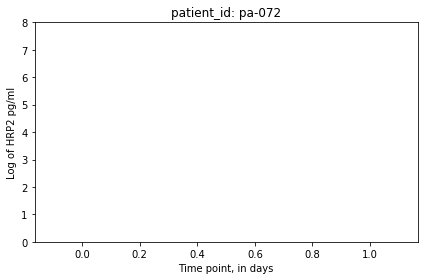

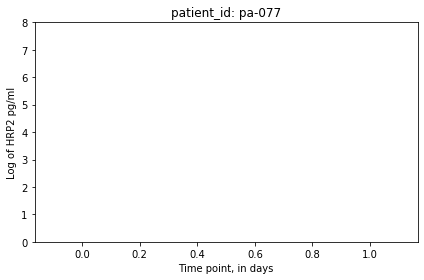

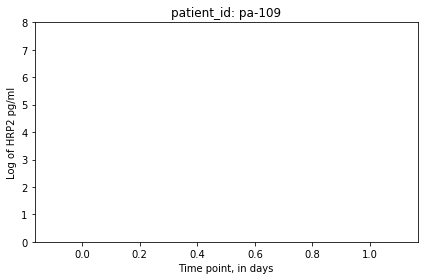

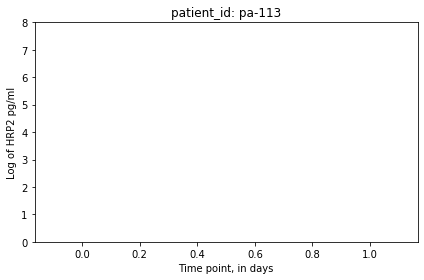

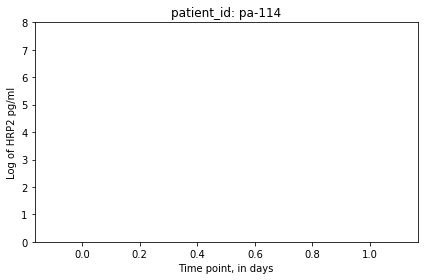

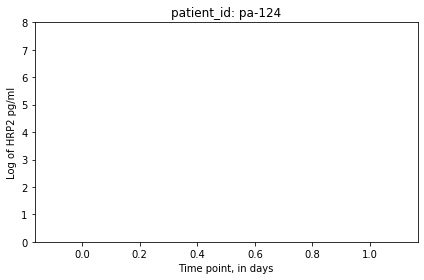

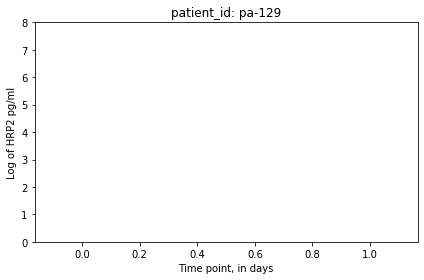

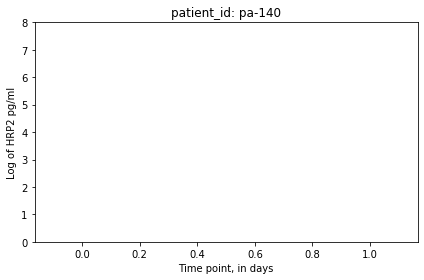

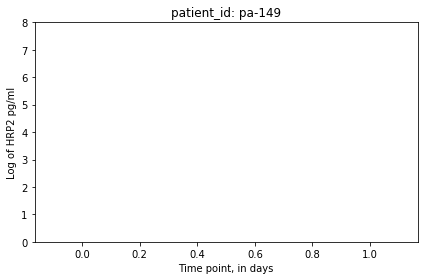

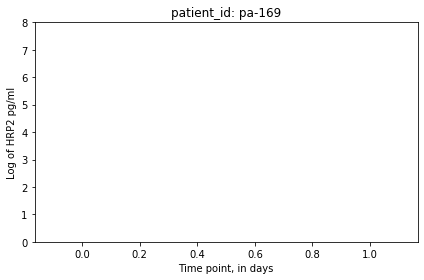

In [10]:
# time_series = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/HRP2_timeseries.pdf')
# for pid in rebuilt_data['patient_id'].unique():
for pid in problem_pids:
    good_vals = good_df.loc[good_df['patient_id'] == pid]
    good_vals['group'] = 'blue'
    bad_vals = bad_df.loc[bad_df['patient_id'] == pid]
    bad_vals['group'] = 'red'
    combo = pd.concat([good_vals, bad_vals])
    combo = combo.sort_values('time_point_days')
    f = plt.figure()
    f.add_subplot()
    title = "patient_id: {}".format(pid)
    plt.plot(combo['time_point_days'], combo['HRP2_pg_ml'],
            c='black', alpha=0.6)
    plt.plot(combo['time_point_days'], combo['LDH_Pan_pg_ml'], c='green', alpha=0.6)
    plt.scatter(combo['time_point_days'], combo['HRP2_pg_ml'],
                c=combo['group'])
    plt.title(title)
    plt.ylim(0,8)
    plt.xlabel('Time point, in days')
    plt.ylabel('Log of HRP2 pg/ml')
    plt.tight_layout()
    plt.show()
#     time_series.savefig(f)
    plt.close()
# time_series.close()